In [1]:
import pandas as pd

# load transactions
df = pd.read_csv("files/transactional-sample.csv", sep=",")
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False


In [2]:
# check for transactions with negative amount
len(df[df["transaction_amount"] < 0])

0

In [3]:
# check for duplicate transactions
len(df[df.duplicated(["transaction_id"])])

0

In [4]:
# count number of records by column
df.count()

transaction_id        3199
merchant_id           3199
user_id               3199
card_number           3199
transaction_date      3199
transaction_amount    3199
device_id             2369
has_cbk               3199
dtype: int64

In [5]:
# count missing values per column
df.isnull().sum()

transaction_id          0
merchant_id             0
user_id                 0
card_number             0
transaction_date        0
transaction_amount      0
device_id             830
has_cbk                 0
dtype: int64

In [6]:
# convert device_id to integer and put 999999 for missing values
df["device_id"] = df["device_id"].fillna(999999).astype(int)
df.head()

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,999999,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,999999,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232,False


In [7]:
# number of unique values per column
df.nunique()

transaction_id        3199
merchant_id           1756
user_id               2704
card_number           2925
transaction_date      3199
transaction_amount    3124
device_id             1997
has_cbk                  2
dtype: int64

In [8]:
# describe transactions per user
df.groupby("user_id").count()["transaction_id"].describe()

count    2704.000000
mean        1.183062
std         1.052521
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        31.000000
Name: transaction_id, dtype: float64

In [9]:
# count each has_cbk type
df.groupby("has_cbk").count()["transaction_id"]

has_cbk
False    2808
True      391
Name: transaction_id, dtype: int64

In [10]:
# convert transaction_date to datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# remove records with missing values
df = df.dropna() # was not necessary in this case

# convert card_number to integer and remove asterisks
df["card_number"] = df["card_number"].str.replace("*", "").astype(int)

df.count()

transaction_id        3199
merchant_id           3199
user_id               3199
card_number           3199
transaction_date      3199
transaction_amount    3199
device_id             3199
has_cbk               3199
dtype: int64

<Axes: xlabel='transaction_hour'>

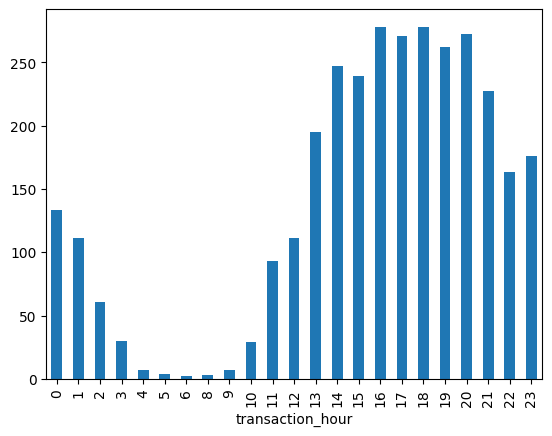

In [11]:
# create column transaction hour
df['transaction_hour'] = df['transaction_date'].dt.hour

# transactions per hour
df.groupby("transaction_hour").count()["transaction_id"].plot.bar()

<Axes: xlabel='transaction_hour'>

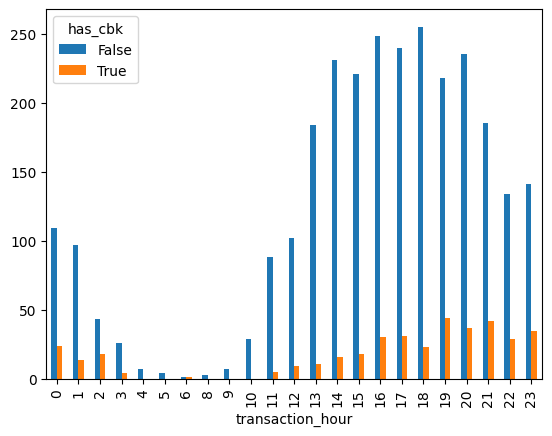

In [12]:
# has_cbk (true/false) per transaction_hour
df.groupby(["transaction_hour", "has_cbk"]).count()["transaction_id"].unstack().plot.bar()

<Axes: xlabel='transaction_hour'>

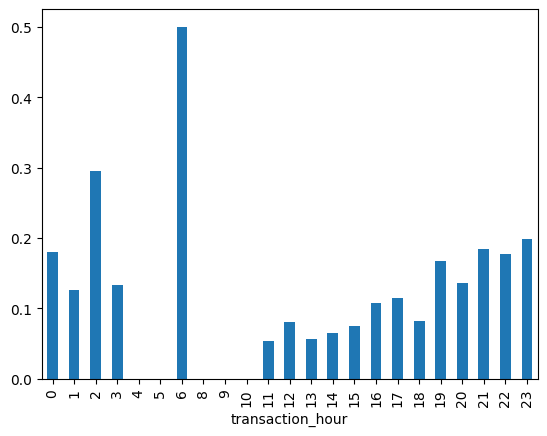

In [13]:
# average has_cbk per transaction_hour
df.groupby("transaction_hour").mean()["has_cbk"].plot.bar()

<Axes: xlabel='transaction_weekday'>

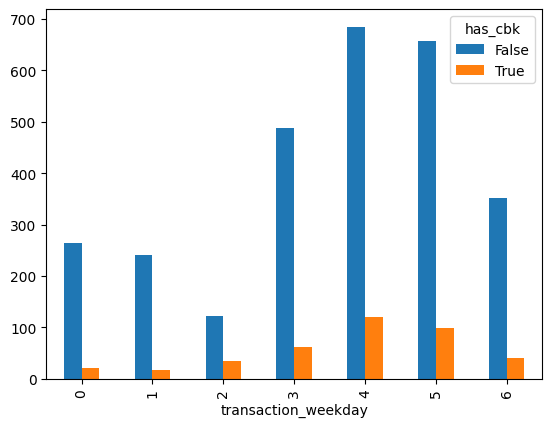

In [14]:
# create column transaction week day
df["transaction_weekday"] = df["transaction_date"].dt.weekday

# has_cbk (true/false) per transaction_weekday
df.groupby(["transaction_weekday", "has_cbk"]).count()["transaction_id"].unstack().plot.bar()

<Axes: xlabel='transaction_weekday'>

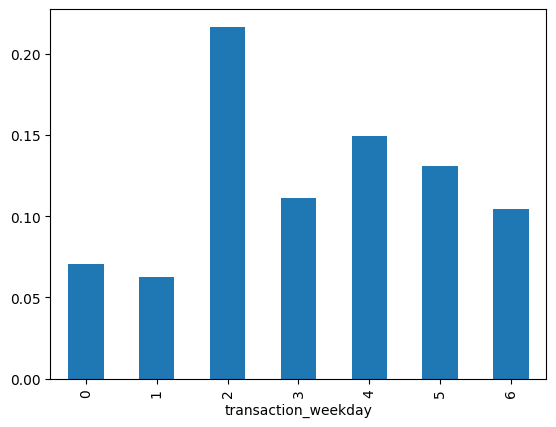

In [15]:
# average has_cbk per transaction_weekday
df.groupby("transaction_weekday").mean()["has_cbk"].plot.bar()

<Axes: xlabel='mii'>

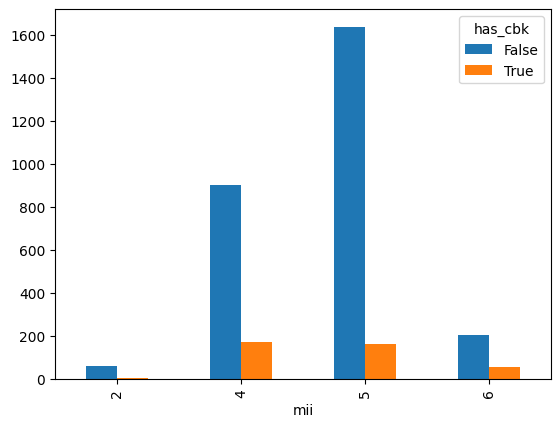

In [16]:
# create a column with Major Industry Identifier (MII)
df["mii"] = df["card_number"].astype(str).str[0].astype(int)

# has_cbk (true/false) per mii
df.groupby(["mii", "has_cbk"]).count()["transaction_id"].unstack().plot.bar()

<Axes: xlabel='mii'>

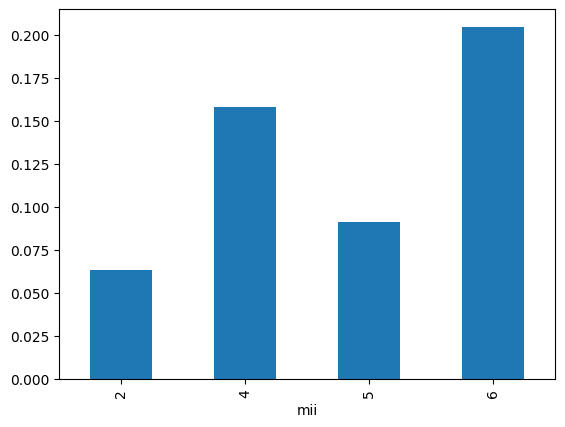

In [17]:
# average has_cbk per mii
df.groupby("mii").mean()["has_cbk"].plot.bar()

In [18]:
from sklearn.model_selection import train_test_split

# remove columns that are not needed, and split data to train and test
X = df.drop(['has_cbk', 'transaction_date', 'card_number'], axis=1)
y = df['has_cbk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# set parameters to randomly combine
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'class_weight': ['balanced', 'balanced_subsample', {False: 1, True: 10}, {False: 1, True: 20}, {False: 1, True: 30}, {False: 1, True: 50}]
}

# find best parameters randomly (save time)
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=500, cv=3, random_state=42, n_jobs=-1, verbose=2)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_

model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] END bootstrap=True, class_weight={False: 1, True: 30}, criterion=gini, max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, class_weight={False: 1, True: 10}, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END bootstrap=True, class_weight={False: 1, True: 10}, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, class_weight={False: 1, True: 10}, criterion=gini, max_depth=30, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.1s
[CV] END bootstrap=True, class_weight={False: 1, True: 30}, criterion=gini, max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.6s
[CV] END bootstrap=True, class_weight={False: 1, True: 30}, criterion=gini, max_depth=40, min_sa

RandomForestClassifier(class_weight={False: 1, True: 10}, criterion='entropy',
                       max_depth=40, min_samples_leaf=2, n_estimators=400)

In [20]:
from sklearn.metrics import classification_report

# model results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

# RandomForestClassifier(class_weight={False: 1, True: 10}, criterion='entropy', max_depth=40, min_samples_leaf=2, n_estimators=400)
#               precision    recall  f1-score   support

#        False       0.93      0.99      0.96       550
#         True       0.86      0.57      0.68        90

#     accuracy                           0.93       640
#    macro avg       0.90      0.78      0.82       640
# weighted avg       0.92      0.93      0.92       640

              precision    recall  f1-score   support

       False       0.93      0.99      0.96       550
        True       0.88      0.54      0.67        90

    accuracy                           0.93       640
   macro avg       0.90      0.77      0.81       640
weighted avg       0.92      0.93      0.92       640



In [21]:
# save model to be used in the API
from joblib import dump
dump(model, 'files/model.joblib')

['files/model.joblib']

In [22]:
# test saved model
import pandas as pd
from joblib import load
model = load('files/model.joblib')

# make predictions for a single row
data = {
    'transaction_id': 2342357,
    'merchant_id': 29744,
    'user_id': 97051,
    'transaction_amount': 373.56,
    'device_id': 285475,
    'transaction_hour': 23,
    'transaction_weekday': 6,
    'mii': 4
}
test_df = pd.DataFrame([data])
model.predict(test_df)[0]

False